# ВЫВОДЫ по работе

Accuracy с Tanh получилась лучше, чем с sigmoid:

Лучшая численная стабильность при обратном распространении ошибки
Уменьшение проблемы исчезающих градиентов по сравнению с Sigmoid

Наблюдаемые результаты по Аугментациям

На основе анализа графиков Accuracy и скорости сходимости было установлено,
что различные виды аугментаций данных не оказывают существенного влияния на
конечное качество модели и динамику обучения.

Для MNIST аугментации не являются необходимыми

In [3]:
import numpy as np

class Linear:
    def __init__(self, input_size, output_size):
        '''
        Creates weights and biases for linear layer.
        Dimention of inputs is *input_size*, of output: *output_size*.
        '''
        #### YOUR CODE HERE
        #### Create weights, initialize them with samples from N(0, 0.1).
        self.W = np.random.randn(input_size, output_size)*0.01
        self.b = np.zeros(output_size)

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, input_size).
        Returns output of size (N, output_size).
        Hint: You may need to store X for backward pass
        '''
        self.X = X
        return X.dot(self.W)+self.b

    def backward(self, dLdy):
        '''
        1. Compute dLdw and dLdx.
        2. Store dLdw for step() call
        3. Return dLdx
        '''
        self.dLdW = self.X.T.dot(dLdy)
        self.dLdb = dLdy.sum(0)
        self.dLdx = dLdy.dot(self.W.T)
        return self.dLdx

    def step(self, learning_rate):
        '''
        1. Apply gradient dLdw to network:
        w <- w - learning_rate*dLdw
        '''
        self.W = self.W - learning_rate * self.dLdW
        self.b = self.b - learning_rate * self.dLdb

class Sigmoid:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.s = 1./(1+np.exp(-X))
        return self.s

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return self.s*(1-self.s)*dLdy

    def step(self, learning_rate):
        pass

class NLLLoss:
    def __init__(self):
        '''
        Applies Softmax operation to inputs and computes NLL loss
        '''
        pass

    def forward(self, X, y):
        '''
        Passes objects through this layer.
        X is np.array of size (N, C), where C is the number of classes
        y is np.array of size (N), contains correct labels
        '''
        self.p = np.exp(X)
        self.p /= self.p.sum(1, keepdims=True)
        self.y = np.zeros((X.shape[0], X.shape[1]))
        self.y[np.arange(X.shape[0]), y] = 1
        return -(np.log(self.p)*self.y).sum(1).mean(0)

    def backward(self):
        '''
        Note that here dLdy = 1 since L = y
        1. Compute dLdx
        2. Return dLdx
        '''
        return (self.p - self.y) / self.y.shape[0]


class NeuralNetwork:
    def __init__(self, modules):
        '''
        Constructs network with *modules* as its layers
        '''
        self.modules = modules

    def forward(self, X):
        y = X
        for i in range(len(self.modules)):
            y = self.modules[i].forward(y)
        return y

    def backward(self, dLdy):
        '''
        dLdy here is a gradient from loss function
        '''
        for i in range(len(self.modules))[::-1]:
            dLdy = self.modules[i].backward(dLdy)

    def step(self, learning_rate):
        for i in range(len(self.modules)):
            self.modules[i].step(learning_rate)

In [2]:
!pip3 install torch torchvision

  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/f0/d7/15d3d7bd8d0239211b21673d1bac7bc345a4ad904a8e25bb3fd8a9cf1fbc/torchvision-0.23.0-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/a4/5e/05a5c46085d9b97e928f3f037081d3d2b87fb4b4195030fc099aaec5effc/torch-2.8.0-cp311-none-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for sympy>=1.13.3 from https://files.pythonhosted.org/packages/a2/09/77d55d46fd61b4a135c444fc97158ef34a095e5681d0a6c10b75bf356191/sympy-1.14.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 5.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 MB 7.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 8.5 MB/s eta 0:00:0000:0100:01m
  Attempting uninstall: sympy
    Found existing installation: sympy 1.11.1
    Uninstalling sympy-

In [4]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import sys
from IPython.display import clear_output
%matplotlib inline

In [67]:
#Здесь я применил аугментации реализованные не через Skimage, потому что те работают только с numpy массивами,
# а чтобы работать с тензорами применил как указывали в чате библиотеку torchvision - консистентность поддержал
#Для написанного уже до меня кода transform
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])

transform_rotation = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

transform_shift = transforms.Compose([
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

class AddGaussianNoise:
    def __init__(self, mean=0., std=0.1):
        self.mean = mean
        self.std = std
        
    def __call__(self, tensor):
        return tensor + torch.randn_like(tensor) * self.std + self.mean

transform_noise = transforms.Compose([
    transforms.ToTensor(),
    AddGaussianNoise(std=0.05),
    transforms.Normalize((0.1307,), (0.3081,))
])

transform_combined = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    AddGaussianNoise(std=0.05),
    transforms.Normalize((0.1307,), (0.3081,))
])


train_datasets = {
    'Baseline': MNIST('.', train=True, download=True, transform=transform),
    'Rotation': MNIST('.', train=True, download=True, transform=transform_rotation),
    'Shift': MNIST('.', train=True, download=True, transform=transform_shift),
    'Noise': MNIST('.', train=True, download=True, transform=transform_noise),
    'Combined': MNIST('.', train=True, download=True, transform=transform_combined)
}

test_dataset = MNIST('.', train=False, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [68]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

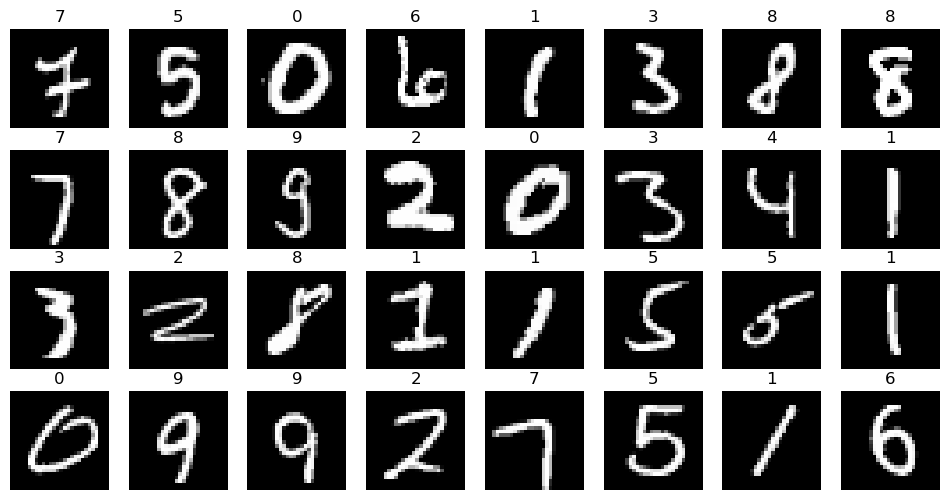

In [7]:
plt.figure(figsize=(12, 6))
for i in range(len(X)):
    plt.subplot(4, 8, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

In [8]:
X[0].shape

(1, 28, 28)

In [9]:
def train(network, epochs, learning_rate, plot=True,
          verbose=True, loss=None):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [70]:
def train_with_augmentations():
    
    results = []
    
    for name, train_dataset in train_datasets.items():
        print(f"\n=== Train {name} ===")
        
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        
        network = NeuralNetwork([
            Linear(784, 100), Sigmoid(),
            Linear(100, 100), Sigmoid(),
            Linear(100, 10)
        ])
        
        train_loss, test_loss, train_acc, test_acc = train(
            network, 12, 0.01)
        
        results.append({
            'name': name,
            'final_train_acc': train_acc[-1],
            'final_test_acc': test_acc[-1],
            'train_acc_history': train_acc,
            'test_acc_history': test_acc,
            'train_loss_history': train_loss,
            'test_loss_history': test_loss,
            'overfitting_gap': train_acc[-1] - test_acc[-1]
        })
    
    return results

Epoch 11... (Train/Test) NLL: 0.539/0.497	Accuracy: 0.857/0.867

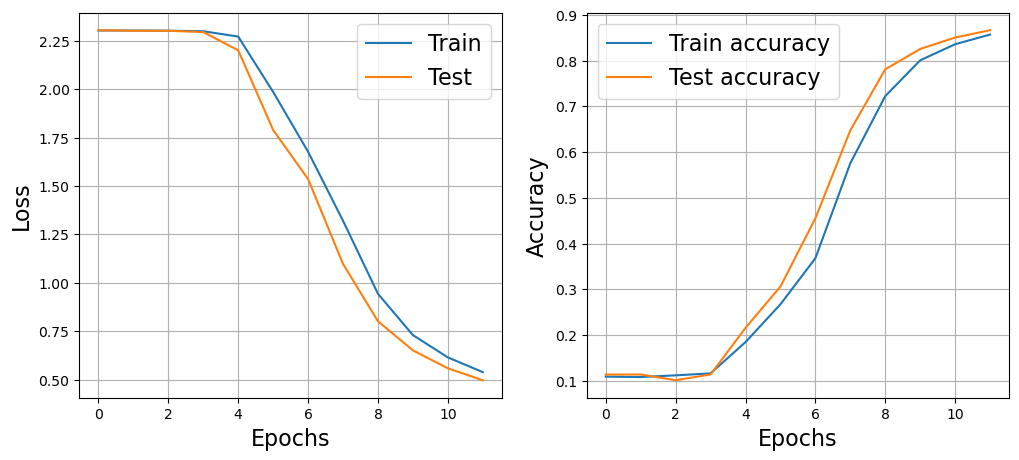

In [71]:
results = train_with_augmentations()

In [72]:
def analyze_results(results):
    
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 1, 1)
    for result in results:
        plt.plot(result['test_acc_history'], label=f"{result['name']} (final: {result['final_test_acc']:.3f})")
    
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Test Accuracy', fontsize=16)
    plt.title('Test Accuracy for Different Augmentations', fontsize=16)
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(True)
    
    plt.subplot(2, 1, 2)
    for result in results:
        plt.plot(result['test_loss_history'], label=f"{result['name']}")
    
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Test Loss', fontsize=16)
    plt.title('Test Loss for Different Augmentations', fontsize=16)
    plt.legend(loc='upper right', fontsize=12)
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    print("\n=== Final Results ===")
    for result in results:
        print(f"{result['name']}: "
              f"Train Acc: {result['final_train_acc']:.4f}, "
              f"Test Acc: {result['final_test_acc']:.4f}, "
              f"Overfitting: {result['overfitting_gap']:.4f}")


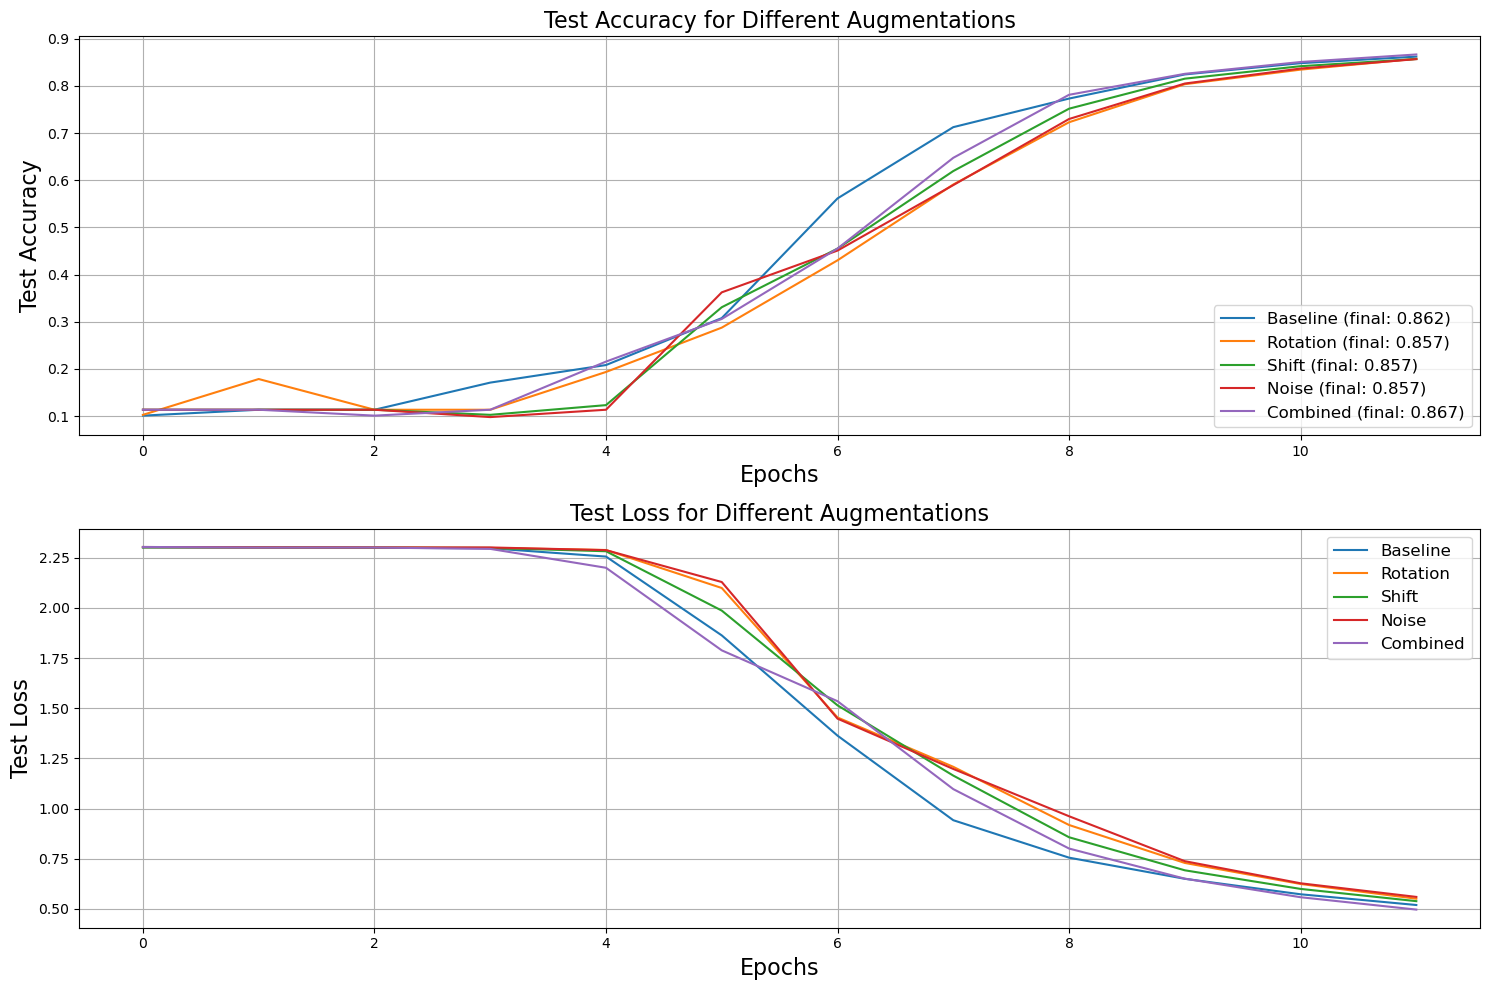


=== Final Results ===
Baseline: Train Acc: 0.8535, Test Acc: 0.8619, Overfitting: -0.0084
Rotation: Train Acc: 0.8421, Test Acc: 0.8573, Overfitting: -0.0152
Shift: Train Acc: 0.8464, Test Acc: 0.8568, Overfitting: -0.0104
Noise: Train Acc: 0.8392, Test Acc: 0.8566, Overfitting: -0.0174
Combined: Train Acc: 0.8570, Test Acc: 0.8665, Overfitting: -0.0095


In [73]:
analyze_results(results)

In [74]:
def calculate_convergence_speed(accuracy_history, threshold=0.9):
    for epoch, acc in enumerate(accuracy_history):
        if acc >= threshold:
            return epoch
    return -1

In [75]:
conv_speed = calculate_convergence_speed(results[0]['test_acc_history'], 0.9)
print(f"Скорость сходимости: {conv_speed} эпох")

for i, result in enumerate(results):
    conv_speed_08 = calculate_convergence_speed(result['test_acc_history'], 0.8)
    conv_speed_085 = calculate_convergence_speed(result['test_acc_history'], 0.85)
    conv_speed_09 = calculate_convergence_speed(result['test_acc_history'], 0.9)
    
    print(f"{result['name']}: 0.8={conv_speed_08}, 0.85={conv_speed_085}, 0.9={conv_speed_09}")

Скорость сходимости: -1 эпох
Baseline: 0.8=9, 0.85=11, 0.9=-1
Rotation: 0.8=9, 0.85=11, 0.9=-1
Shift: 0.8=9, 0.85=11, 0.9=-1
Noise: 0.8=9, 0.85=11, 0.9=-1
Combined: 0.8=9, 0.85=10, 0.9=-1


In [76]:
def train_with_augmentations_ReLU():
    
    results_ReLU = []
    
    for name, train_dataset in train_datasets.items():
        print(f"\n=== Train {name} ===")
        
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        
        network = NeuralNetwork([
            Linear(784, 100), ReLU(),
            Linear(100, 100), ReLU(),
            Linear(100, 10)
        ])
        NLLLoss()
        train_loss_r, test_loss_r, train_acc_r, test_acc_r = train(
            network, 8, 0.01)
        
        results_ReLU.append({
            'name': name,
            'final_train_acc': train_acc_r[-1],
            'final_test_acc': test_acc_r[-1],
            'train_acc_history': train_acc_r,
            'test_acc_history': test_acc_r,
            'train_loss_history': train_loss_r,
            'test_loss_history': test_loss_r,
            'overfitting_gap': train_acc_r[-1] - test_acc_r[-1]
        })
    
    return results_ReLU

Epoch 7... (Train/Test) NLL: 0.114/0.115	Accuracy: 0.967/0.967

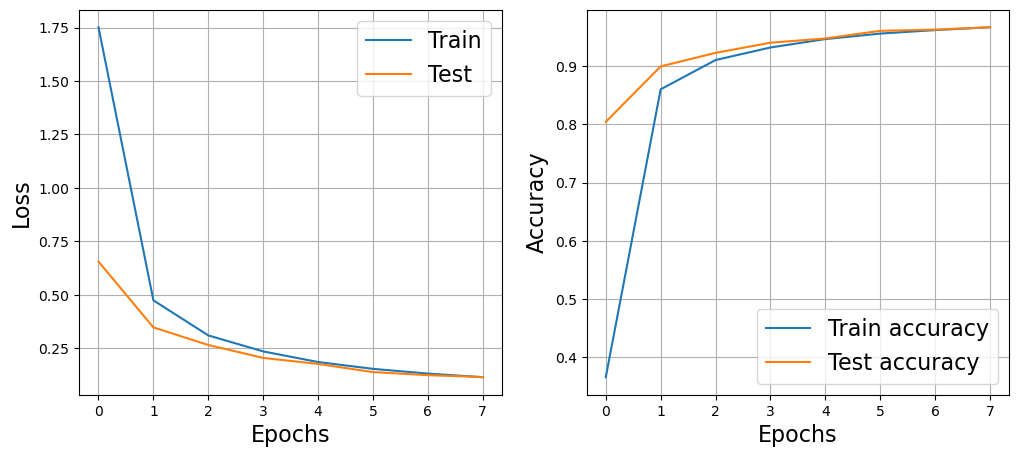

In [77]:
results_ReLU = train_with_augmentations_ReLU()

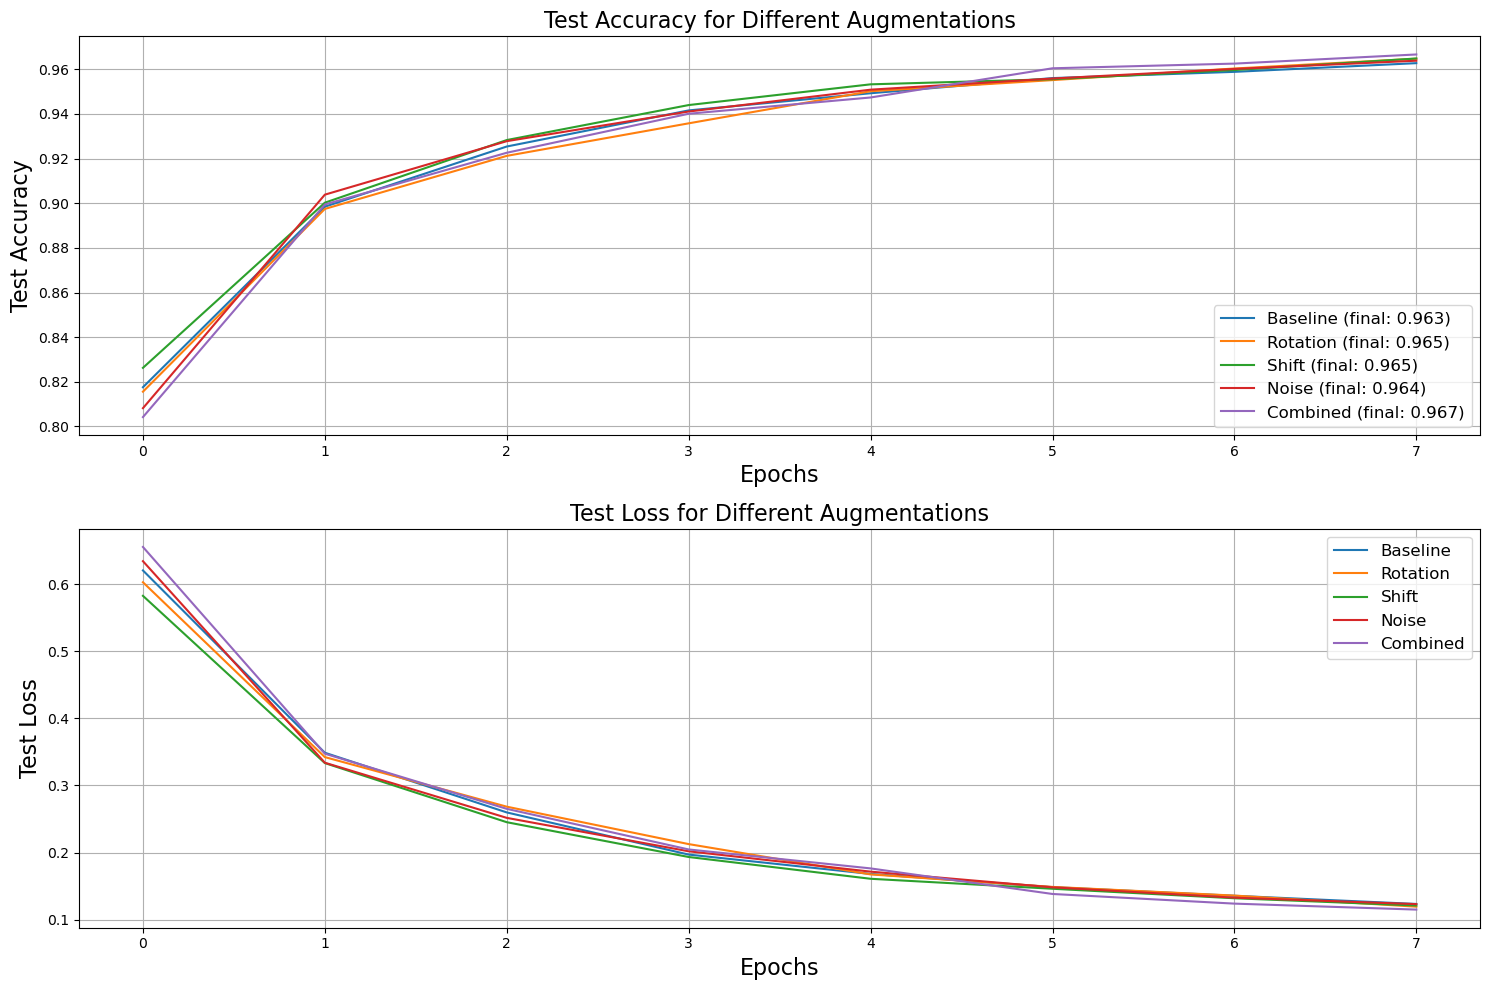


=== Final Results ===
Baseline: Train Acc: 0.9665, Test Acc: 0.9628, Overfitting: 0.0038
Rotation: Train Acc: 0.9658, Test Acc: 0.9648, Overfitting: 0.0010
Shift: Train Acc: 0.9669, Test Acc: 0.9649, Overfitting: 0.0020
Noise: Train Acc: 0.9668, Test Acc: 0.9639, Overfitting: 0.0029
Combined: Train Acc: 0.9666, Test Acc: 0.9667, Overfitting: -0.0000


In [78]:
analyze_results(results_ReLU)

In [79]:
conv_speed = calculate_convergence_speed(results_ReLU[0]['test_acc_history'], 0.9)
print(f"Скорость сходимости: {conv_speed} эпох")

for i, result in enumerate(results_ReLU):
    conv_speed_08 = calculate_convergence_speed(result['test_acc_history'], 0.8)
    conv_speed_085 = calculate_convergence_speed(result['test_acc_history'], 0.85)
    conv_speed_09 = calculate_convergence_speed(result['test_acc_history'], 0.9)
    
    print(f"{result['name']}: 0.8={conv_speed_08}, 0.85={conv_speed_085}, 0.9={conv_speed_09}")

Скорость сходимости: 2 эпох
Baseline: 0.8=0, 0.85=1, 0.9=2
Rotation: 0.8=0, 0.85=1, 0.9=2
Shift: 0.8=0, 0.85=1, 0.9=1
Noise: 0.8=0, 0.85=1, 0.9=1
Combined: 0.8=0, 0.85=1, 0.9=2


In [80]:
def train_with_augmentations_Tanh():
    
    results_Tanh = []
    
    for name, train_dataset in train_datasets.items():
        print(f"\n=== Train {name} ===")
        
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        
        network = NeuralNetwork([
            Linear(784, 100), Tanh(),
            Linear(100, 100), Tanh(),
            Linear(100, 10)
        ])
        NLLLoss()
        train_loss_t, test_loss_t, train_acc_t, test_acc_t = train(
            network, 6, 0.01)
        
        results_Tanh.append({
            'name': name,
            'final_train_acc': train_acc_t[-1],
            'final_test_acc': test_acc_t[-1],
            'train_acc_history': train_acc_t,
            'test_acc_history': test_acc_t,
            'train_loss_history': train_loss_t,
            'test_loss_history': test_loss_t,
            'overfitting_gap': train_acc_t[-1] - test_acc_t[-1]
        })
    
    return results_Tanh

Epoch 5... (Train/Test) NLL: 0.138/0.139	Accuracy: 0.962/0.961

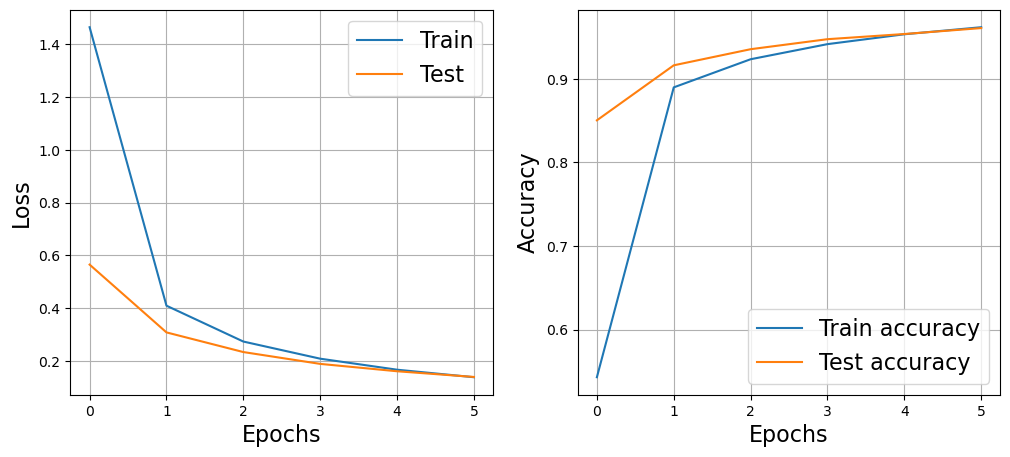

In [81]:
results_Tanh = train_with_augmentations_Tanh()

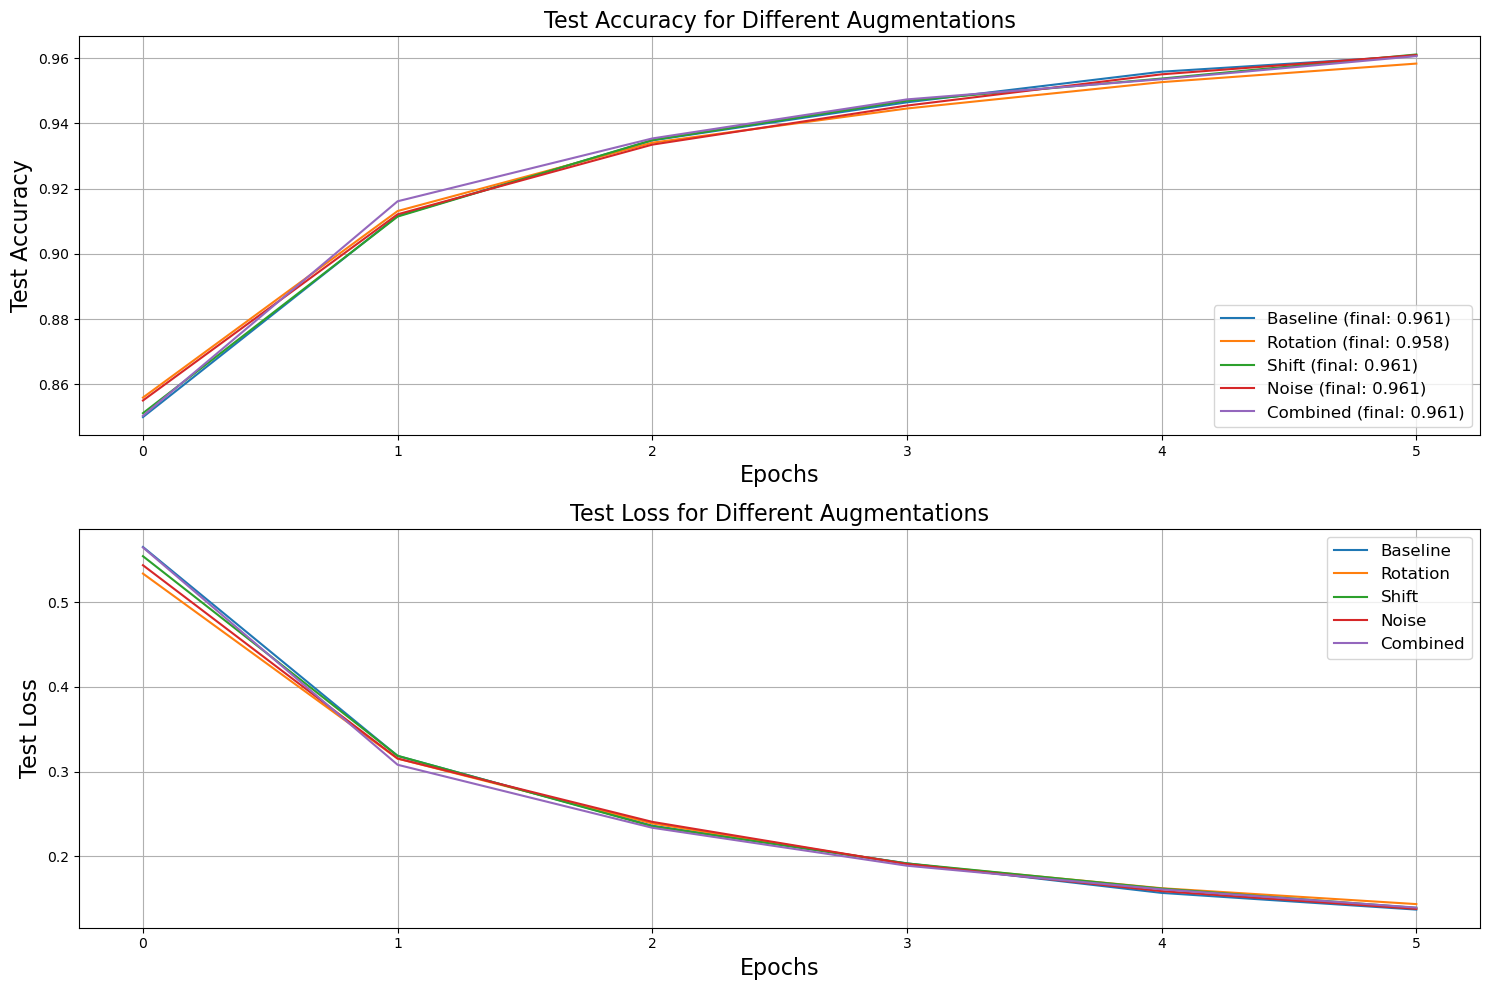


=== Final Results ===
Baseline: Train Acc: 0.9597, Test Acc: 0.9608, Overfitting: -0.0011
Rotation: Train Acc: 0.9599, Test Acc: 0.9584, Overfitting: 0.0015
Shift: Train Acc: 0.9600, Test Acc: 0.9612, Overfitting: -0.0011
Noise: Train Acc: 0.9602, Test Acc: 0.9610, Overfitting: -0.0007
Combined: Train Acc: 0.9617, Test Acc: 0.9607, Overfitting: 0.0010


In [82]:
analyze_results(results_Tanh)

In [83]:
conv_speed = calculate_convergence_speed(results_Tanh[0]['test_acc_history'], 0.9)
print(f"Скорость сходимости: {conv_speed} эпох")

for i, result in enumerate(results_Tanh):
    conv_speed_08 = calculate_convergence_speed(result['test_acc_history'], 0.8)
    conv_speed_085 = calculate_convergence_speed(result['test_acc_history'], 0.85)
    conv_speed_09 = calculate_convergence_speed(result['test_acc_history'], 0.9)
    
    print(f"{result['name']}: 0.8={conv_speed_08}, 0.85={conv_speed_085}, 0.9={conv_speed_09}")

Скорость сходимости: 1 эпох
Baseline: 0.8=0, 0.85=1, 0.9=1
Rotation: 0.8=0, 0.85=0, 0.9=1
Shift: 0.8=0, 0.85=0, 0.9=1
Noise: 0.8=0, 0.85=0, 0.9=1
Combined: 0.8=0, 0.85=0, 0.9=1


In [84]:
network = NeuralNetwork([
    Linear(784, 100), Sigmoid(), # 28 * 28
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)
])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.308/0.301	Accuracy: 0.919/0.921

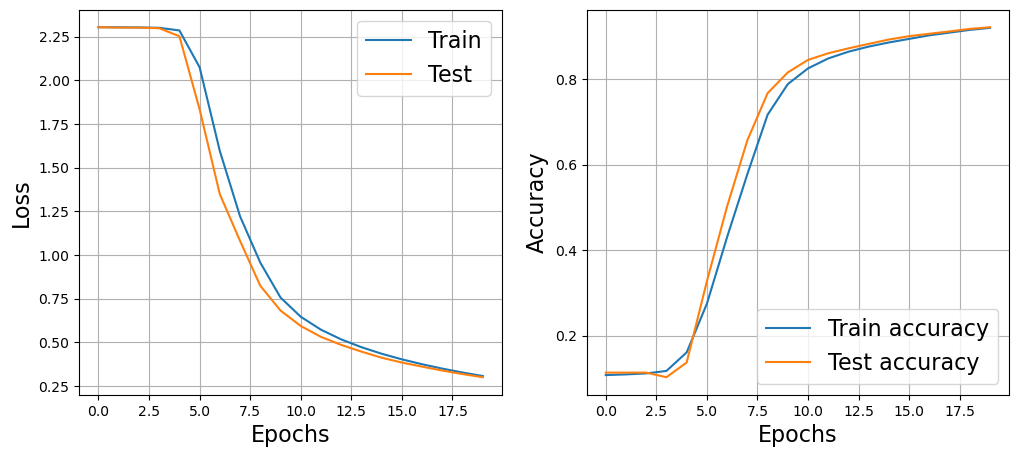

In [11]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, 20, 0.01)

In [18]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (self.X > 0) * dLdy

    def step(self, learning_rate):
        pass


class ELU:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''

    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy*dydX

    def step(self, learning_rate):
        pass
    
class Tanh:
    def __init__(self):
        pass

    def forward(self, X):
        self.X = X
        return (np.exp(2*X) - 1) / (np.exp(2*X) + 1)

    def backward(self, dLdy):
        tanh = (np.exp(2*self.X) - 1) / (np.exp(2*self.X) + 1)
        return (1 - tanh**2) * dLdy

    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.036/0.080	Accuracy: 0.990/0.975

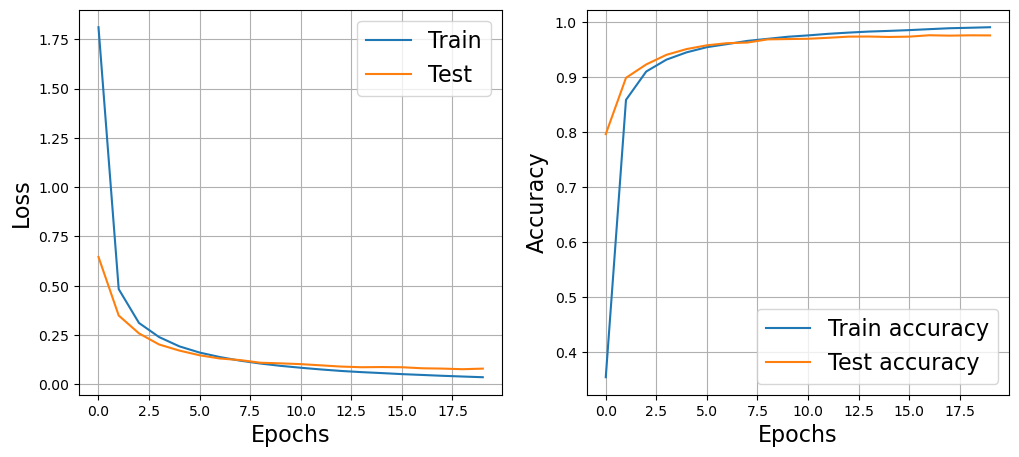

In [13]:
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, 20, 0.01, plot=True, verbose=True)

Epoch 19... (Train/Test) NLL: 0.047/0.082	Accuracy: 0.986/0.975

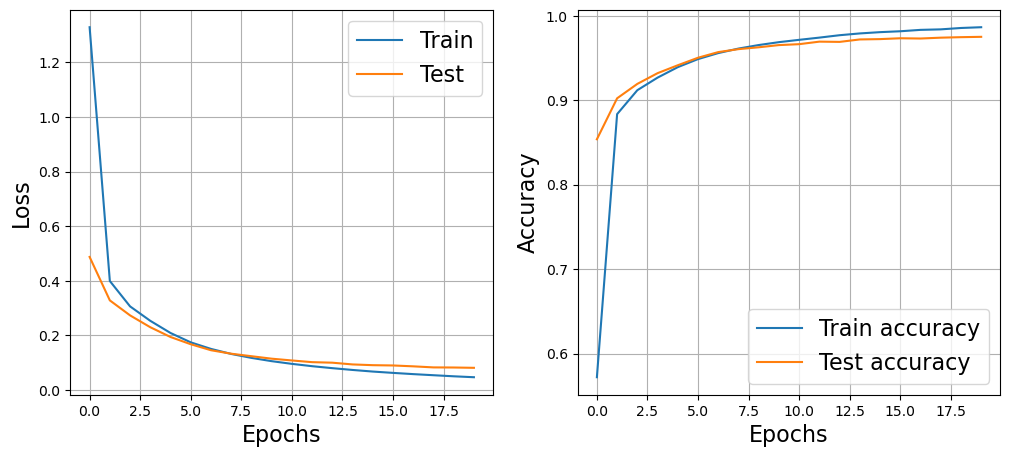

In [21]:
network = NeuralNetwork([Linear(784, 100), ELU(),
               Linear(100, 100), ELU(),
               Linear(100, 10)])
loss = NLLLoss()
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, 20, 0.01, plot=True, verbose=True)

Epoch 19... (Train/Test) NLL: 0.031/0.076	Accuracy: 0.994/0.976

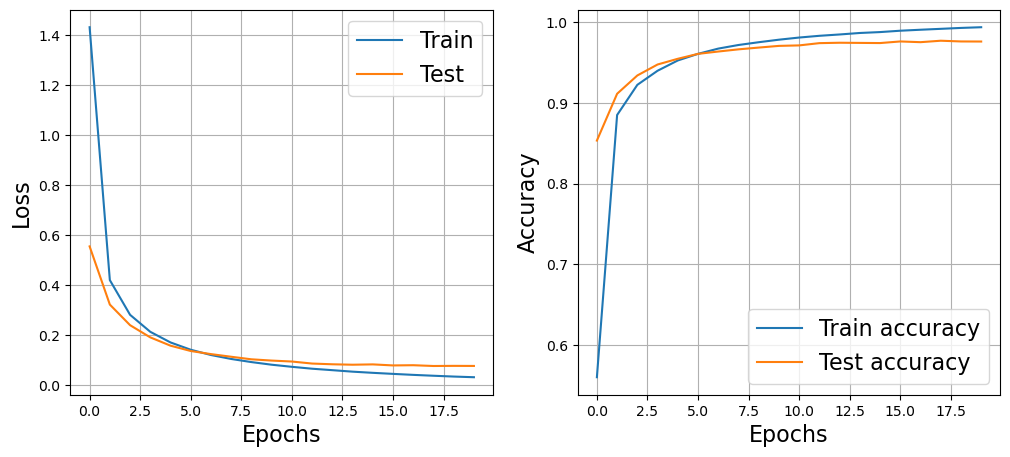

In [22]:
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
loss = NLLLoss()
tr_t, ts_t, tr_ac_t, ts_ac_t = train(network, 20, 0.01, plot=True, verbose=True)

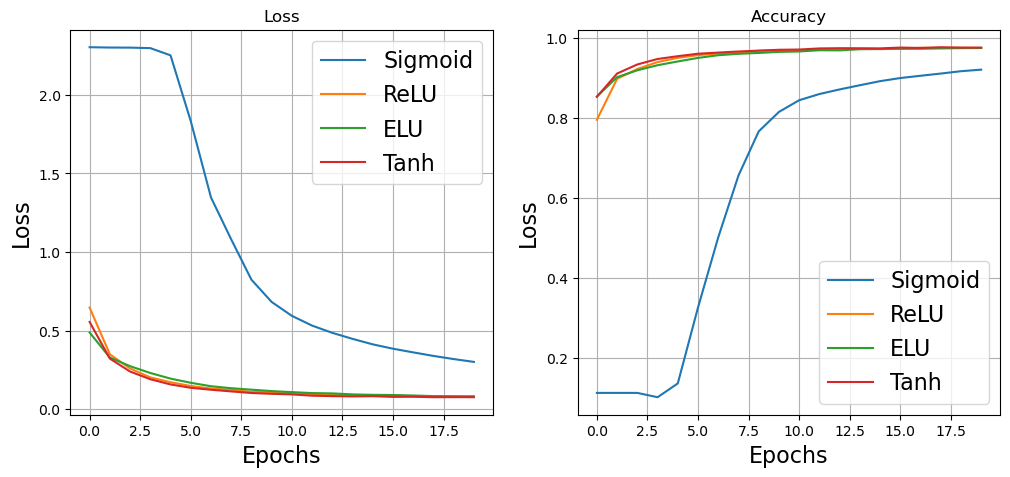

In [23]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.plot(ts_t, label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.plot(ts_ac_t, label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

In [16]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    prediction = network.forward(X)
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

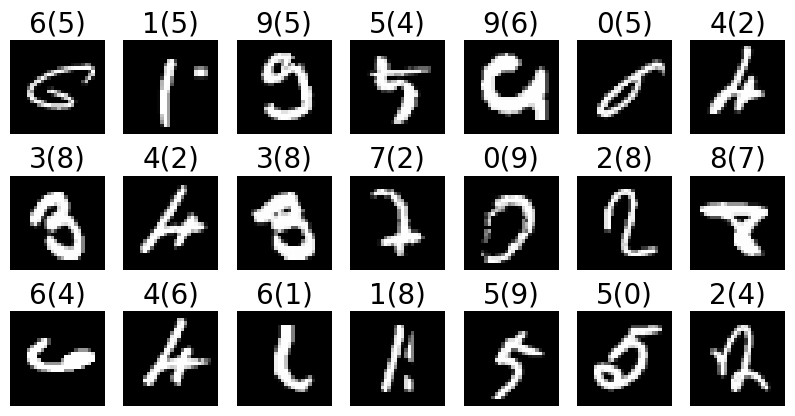

In [17]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')